# Test JPL webpageclassifier

Using data from THH set.


In [325]:
!pwd

/Users/Charles.Twardy/PycharmProjects/thh-classifiers


In [349]:
import pandas as pd
pd.set_option('display.chop_threshold', 1e-5)
pd.set_option('display.latex.repr', True)
pd.set_option('display.precision', 2)
scores = pd.read_csv('../webpageclassifier/scores.csv')
scores = scores.drop('Unnamed: 0', axis=1)
len(scores)

522

### Distribution of Confidence by Category

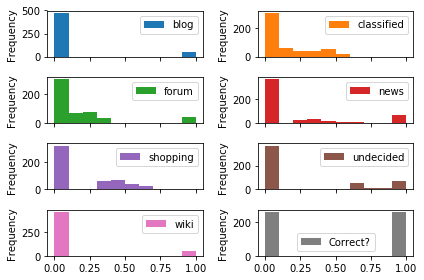

In [350]:
import matplotlib.pyplot as plt
%matplotlib inline
scores.plot.hist(subplots=True, layout=(4,2))
plt.tight_layout()

### Raw Accuracy by Category
Note that the JPL classifier knows nothing of _search_engines_, so the 0 is uninformative. It also has a hard time telling _classified_ from _shopping_, at least in this incarnation.

In [363]:
scores.filter(['pagetype','Correct?']).groupby('pagetype').mean()

,Correct?
pagetype,
blogs,0.67
classified,0.08
forums,0.63
news,0.64
search_engines,0.00
shopping,0.72
wiki,0.80


### Brier Score
All scores are in [0,1], so squared loss on $x^2$ or $(1-x)^2$ makes sense, but it's not a true Brier score because these scores are unnormalized: they do not usually sum to 1.0 For quick benchmark, we compare them to a uniform $1/k$ forecast for $k=8$ categories.

In [368]:
scores.ix[0]

note                         NaN
pagetype                shopping
realurl                      NaN
url           http://vodafone.ie
Best                    shopping
blog                           0
classified                  0.42
forum                       0.18
news                        0.27
shopping                    0.45
undecided                      0
wiki                           0
Plural                 shoppings
Correct?                    True
Name: 0, dtype: object

In [392]:
brier_tot, hits, N = 0, 0, len(scores)
for i in range(N):
    row = scores.ix[i]
    cat = row['pagetype'][:4]
    brier_row = 0
    if row['Correct?']:
        hits += 1
    for col in ['blog','classified','forum','news','shopping','undecided','wiki']:
        val = row[col]
        if col.startswith(cat):
            brier_row += (1-val)**2
        else:
            brier_row += val**2
    brier_tot += brier_row
brier = brier_tot/N
print('Accuracy: {:5.2f} = {:d}/{:d}'.format(hits/N, hits, N))
print('Brier   : {:5.2f}'.format(brier))
print('Uniform : {:5.2f}'.format((1/7)**2 + (6/7)**2))

Accuracy:  0.50 = 260/522
Brier   :  0.68
Uniform :  0.76


So... hit rate so-so but clearly better than uniform guess. OTOH, Brier is only about 11% better than uniform, so not well-calibrated. Likely getting clobbered on some 1/0 guesses.

#### Normalize...

In [333]:
vals = scores.filter(['blog','classified','forum','news','shopping','undecided','wiki'])
totals = vals.sum(axis=1)
probs = vals.divide(totals, axis=0)
probs['pagetype'] = scores['pagetype']
p2 = probs.groupby('pagetype')
p2.mean()

,blog,classified,forum,news,shopping,undecided,wiki
pagetype,,,,,,,
blogs,6.71e-01,0.04,0.06,5.18e-02,0.06,0.11,0.00
classified,0.00e+00,0.18,0.07,4.59e-03,0.24,0.50,0.01
forums,0.00e+00,0.04,0.68,3.03e-02,0.05,0.19,0.00
news,9.01e-03,0.10,0.08,6.22e-01,0.12,0.07,0.00
search_engines,0.00e+00,0.13,0.08,7.57e-02,0.20,0.49,0.02
shopping,0.00e+00,0.22,0.13,1.41e-01,0.40,0.11,0.00
wiki,0.00e+00,0.03,0.01,3.27e-03,0.03,0.13,0.80


In [109]:
p2.sum()

,blog,classified,forum,news,shopping,undecided,wiki
Category,,,,,,,
blog,2.0,1.087669,0.972621,0.547532,0.913231,1.478945,0.0
classified,0.0,4.128168,1.506255,0.260696,4.560287,3.544593,0.0
forum,0.0,1.156890,4.742543,0.279284,0.732880,1.088402,0.0
news,0.0,0.751032,0.874030,4.463309,0.911629,0.000000,0.0
shopping,0.0,1.250387,1.284371,1.446583,2.123414,0.895245,0.0
undecided,0.0,1.508440,0.506151,0.769978,1.410738,3.804693,0.0
wiki,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.0


In [10]:
import timeit
timeit.timeit("D[12]**2", setup="D = dict(((x,2*x) for x in range(1000)))")

0.3456133690197021

In [11]:
timeit.timeit("D[12] * D[12]", setup="D = dict(((x,2*x) for x in range(1000)))")

0.10721423698123544

In [8]:
timeit.timeit("12**2")

0.015308437985368073

In [9]:
timeit.timeit("12*12")

0.015080999000929296

In [13]:
X=['a','b','c','d']
X.remove('c')
X

['a', 'b', 'd']

In [14]:
X += 'e'

In [15]:
X

['a', 'b', 'd', 'e']

In [16]:
timeit.timeit("X += 'f'", setup="X=['a','b','c','d']")

0.11082028108648956

In [17]:
timeit.timeit("X.append('f')", setup="X=['a','b','c','d']")

0.07505967293400317

In [20]:
[(k,v) for k,v in {1:3, 2:3, 3:6}.items()]

[(1, 3), (2, 3), (3, 6)]